### Context Embedding 2D Visualization (PCA)

In [1]:
import torch
from sklearn.preprocessing import StandardScaler

def pca_torch(X, k=2):
    # Center the data
    X_mean = torch.mean(X, dim=0)
    X_centered = X - X_mean

    # Compute the covariance matrix
    cov_matrix = torch.mm(X_centered.t(), X_centered) / (X_centered.size(0) - 1)

    # Perform eigenvalue decomposition
    eigenvalues, eigenvectors = torch.linalg.eig(cov_matrix)
    eigenvalues = eigenvalues.real
    eigenvectors = eigenvectors.real

    # Sort eigenvectors by eigenvalues in descending order
    eigenvectors = eigenvectors.t()  # Transpose to get eigenvectors as rows
    idxs = torch.argsort(eigenvalues, descending=True)
    eigenvalues = eigenvalues[idxs]
    eigenvectors = eigenvectors[idxs]

    # Select the top k eigenvectors (principal components)
    principal_components = eigenvectors[:k]

    # Project the data onto the principal components
    X_pca = torch.mm(X_centered, principal_components.t())

    # Compute explained variance ratios
    explained_variance_ratio = eigenvalues[:k] / torch.sum(eigenvalues)

    return X_pca.numpy(), explained_variance_ratio.numpy()


In [2]:
from collections import defaultdict

seed = 0

# task = 'Ant'
task = 'Anymal'

test_env_names = [f'Contextual{task}TestEasy{i}' for i in range(1,10)] + [f'Contextual{task}TestHard{i}' for i in range(1,5)]

train_env_names = [f'Contextual{task}Train_osi_true', f'Contextual{task}Train_osi', f'Contextual{task}Train_osi_true_student',
                   f'Contextual{task}Train_dm', f'Contextual{task}Train_stacked']

contexts = defaultdict(dict)
for train_env_name in train_env_names:
    train_env_name_keys = [train_env_name]

    for test_env_name in test_env_names:
        if train_env_name.endswith('osi_true') or 'stacked' in train_env_name:
            filenames = [f'../runs/test/seed_{seed}/{test_env_name}/{train_env_name}/99942400/contexts.pt']
        elif train_env_name.endswith('student') or 'dm' in train_env_name:
            filenames = [f'../runs/test/seed_{seed}/{test_env_name}/{train_env_name}/99942400_phase2/contexts.pt']
        elif 'osi' in train_env_name:
            filenames = [f'../runs/test/seed_{seed}/{test_env_name}/{train_env_name}/99942400_phase2/contexts.pt',
                            f'../runs/test/seed_{seed}/{test_env_name}/{train_env_name}/99942400_phase2_raw/contexts.pt']
            train_env_name_keys = [train_env_name, f'{train_env_name}_raw']
        else:
            raise Exception
        
        for train_env_name_key, filename in zip(train_env_name_keys, filenames):
            context_vectors = torch.load(filename)
            context_vectors = torch.stack(context_vectors, dim=0)
            context_vectors = torch.permute(context_vectors, (1, 0, 2))
            context_vectors = context_vectors.reshape((-1, 10)) if not train_env_name_key.endswith('raw') else context_vectors.reshape((-1, 2))
            contexts[train_env_name_key][test_env_name] = context_vectors

    for train_env_name_key in train_env_name_keys:
        all_contexts = torch.stack(list(contexts[train_env_name_key].values()), dim=0)
        all_contexts = all_contexts.reshape((-1, 10)) if not train_env_name_key.endswith('raw') else all_contexts.reshape((-1, 2))
        contexts[train_env_name_key]['ALL'] = all_contexts

In [3]:
embeddings_2d_pcas, explained_variance_ratios = {}, {}

for key in contexts:
    X = contexts[key]['ALL']
    scaler = StandardScaler()
    X_standardized = torch.from_numpy(scaler.fit_transform(X))
    embeddings_2d_pcas[key], explained_variance_ratios[key] = pca_torch(X_standardized , k=2)
    print(f'{key}: Explained Variance Ratio: {explained_variance_ratios[key]}')

ContextualAnymalTrain_osi_true: Explained Variance Ratio: [0.57664346 0.37802205]
ContextualAnymalTrain_osi: Explained Variance Ratio: [0.32828076 0.18620784]
ContextualAnymalTrain_osi_raw: Explained Variance Ratio: [0.60298606 0.39701394]
ContextualAnymalTrain_osi_true_student: Explained Variance Ratio: [0.43680498 0.31545037]
ContextualAnymalTrain_dm: Explained Variance Ratio: [0.24833842 0.20425366]
ContextualAnymalTrain_stacked: Explained Variance Ratio: [0.26320953 0.24190413]


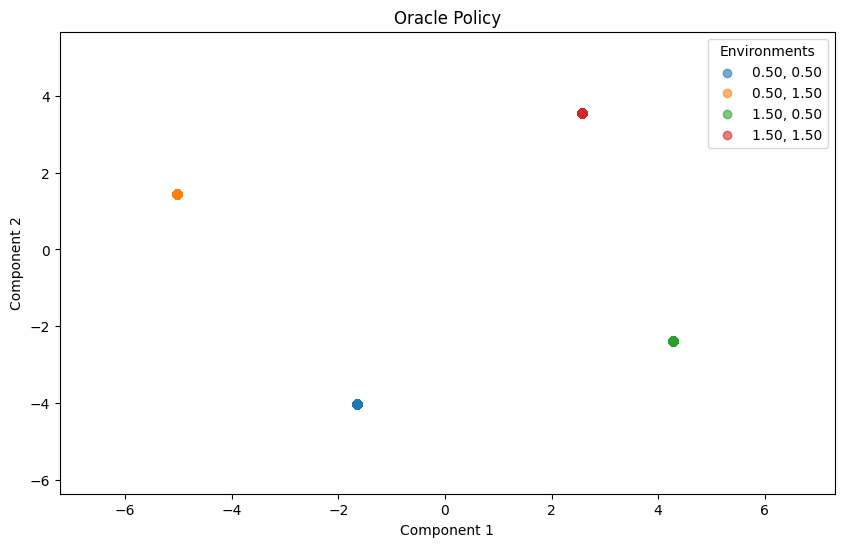

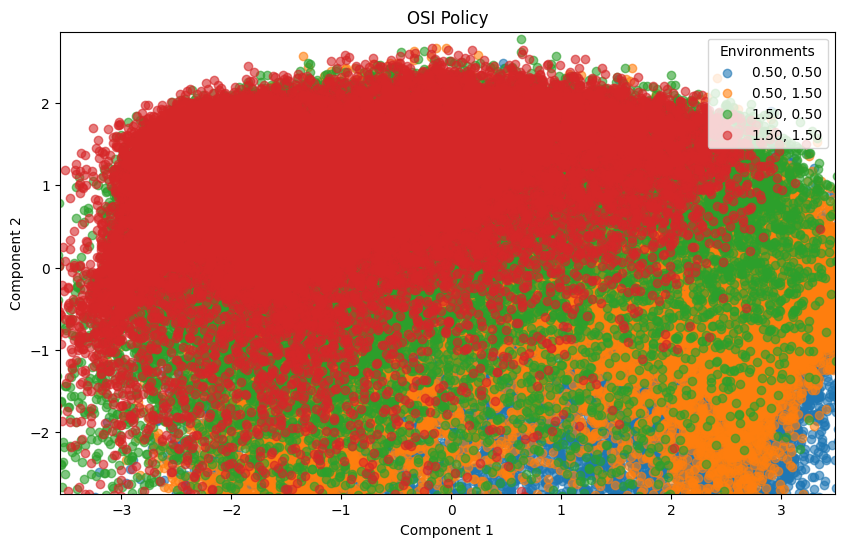

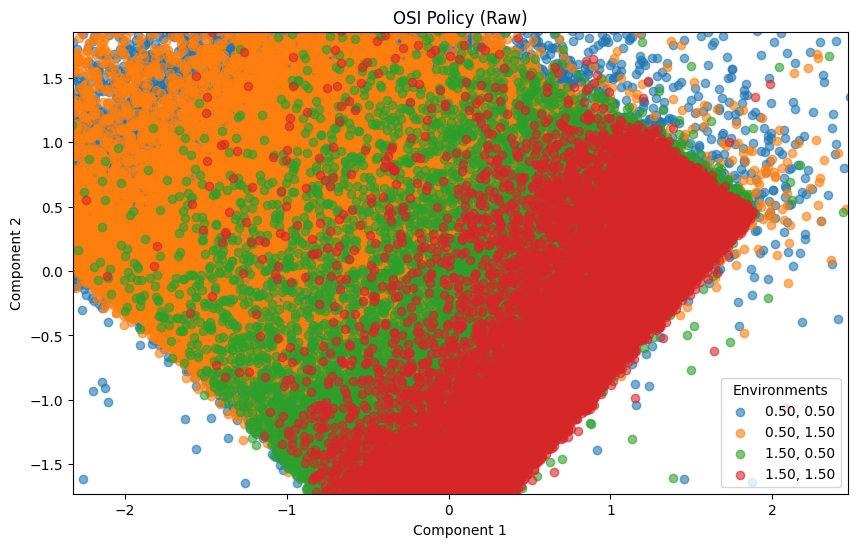

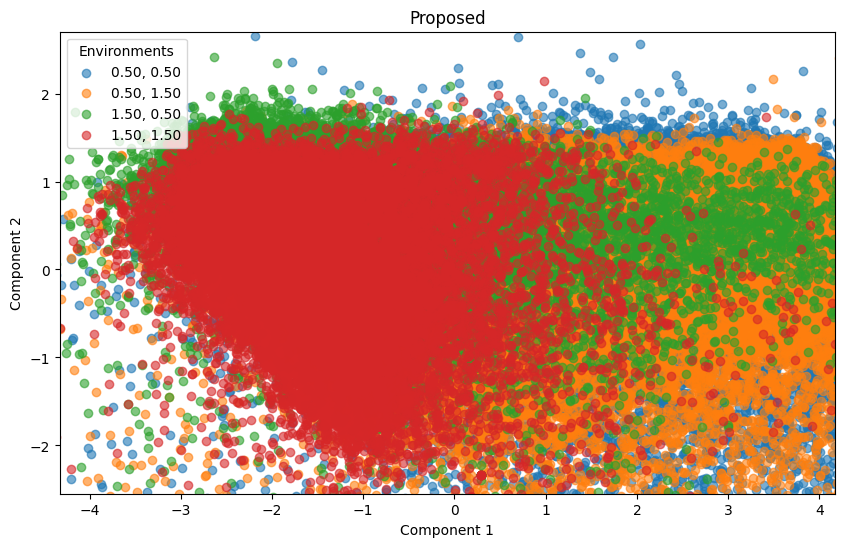

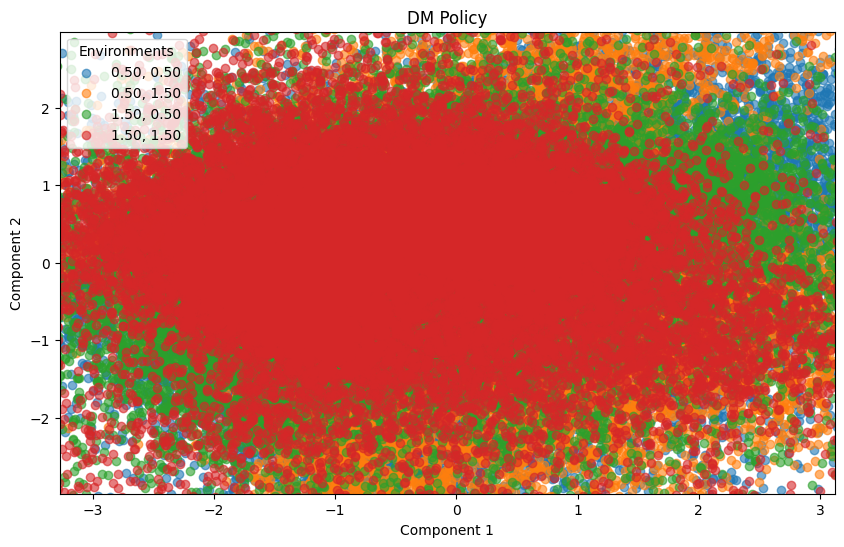

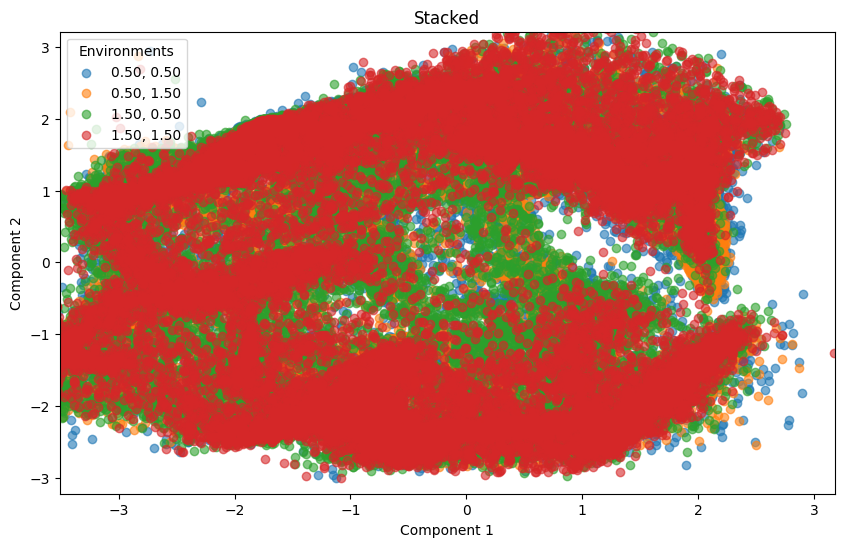

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

sys_params = [
    '0.75, 0.75', '0.75, 1.00', '0.75, 1.25',
    '1.00, 0.75', '1.00, 1.00', '1.00, 1.25',
    '1.25, 0.75', '1.25, 1.00', '1.25, 1.25',
    '0.50, 0.50', '0.50, 1.50',
    '1.50, 0.50', '1.50, 1.50'
]

method_names = [
    'Oracle Policy', 'OSI Policy', 'OSI Policy (Raw)',
    'Proposed', 'DM Policy', 'Stacked'
]

step_size = embeddings_2d_pcas[list(embeddings_2d_pcas.keys())[0]].shape[0]//13
random_sample_ratio = 0.01
random_sample_idx = np.random.permutation(step_size)[:int(step_size * random_sample_ratio)]

cmaps = ['', 'viridis', 'plasma', 'inferno', 'magma']

for train_env_idx, train_env_name in enumerate(contexts):
    embeddings_2d_pca = embeddings_2d_pcas[train_env_name]

    plt.figure(figsize=(10, 6))
    for test_env_idx, (test_env_name, context) in enumerate(contexts[train_env_name].items()):
        if test_env_name == 'ALL':
            continue

        if 'Easy' in test_env_name:
            continue

        if 'Hard' not in test_env_name:
            continue

        target_embeddings = embeddings_2d_pca[test_env_idx*step_size:test_env_idx*step_size+step_size]
        target_embeddings = target_embeddings[random_sample_idx]

        x=target_embeddings[:,0];y=target_embeddings[:,1]

        # # Assuming X is a 2D array of your data points
        # kde = gaussian_kde(target_embeddings.T)

        # # Evaluate density on data points
        # density = kde(target_embeddings.T)

        # Setting the bins for the histogram
        # xbins = np.linspace(embeddings_2d_pca[-step_size*4:,0].min(), embeddings_2d_pca[-step_size*4:,0].max(), 30)
        # ybins = np.linspace(embeddings_2d_pca[-step_size*4:,1].min(), embeddings_2d_pca[-step_size*4:,1].max(), 30)
        xbins = np.linspace(-1.2, 1.2, 30)
        ybins = np.linspace(-1.2, 1.2, 30)

        # plt.hist2d(x, y, bins=[xbins, ybins], cmap=cmaps[int(test_env_name[-1])], density=True, alpha=1, label=sys_params[test_env_idx])

        plt.scatter(target_embeddings[:, 0], target_embeddings[:, 1], alpha=0.6, label=sys_params[test_env_idx])

        # Plot with point sizes proportional to density
        # plt.scatter(target_embeddings[:, 0], target_embeddings[:, 1], s=density*1000, alpha=0.6, label=sys_params[test_env_idx])  # Adjust scaling factor as needed

        # plt.colorbar(label='Density')

    X = embeddings_2d_pca[-step_size*4:,0]
    Y = embeddings_2d_pca[-step_size*4:,1]
    x_mean, y_mean = np.mean(X), np.mean(Y)
    x_std, y_std = np.std(X), np.std(Y)
    plt.xlim(x_mean - 2*x_std, x_mean + 2*x_std)
    plt.ylim(y_mean - 2*y_std, y_mean + 2*y_std)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend(title='Environments')
    # plt.title('PCA-reduced Embeddings')
    plt.title(f'{method_names[train_env_idx]}')
    # plt.xlim(-5, 5)
    # plt.ylim(-5, 5)
    plt.show()

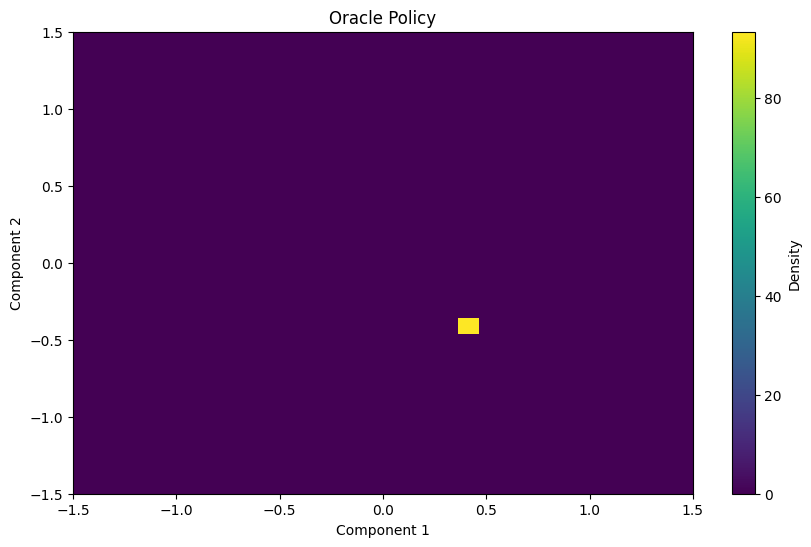

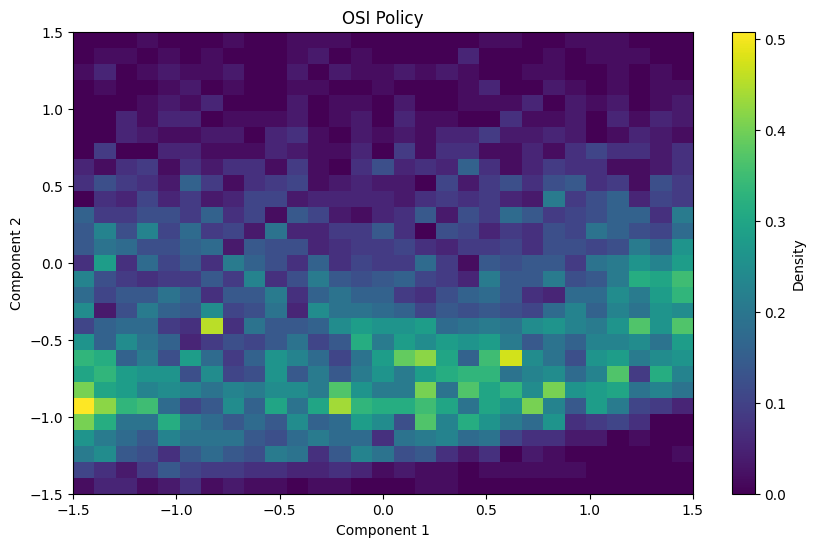

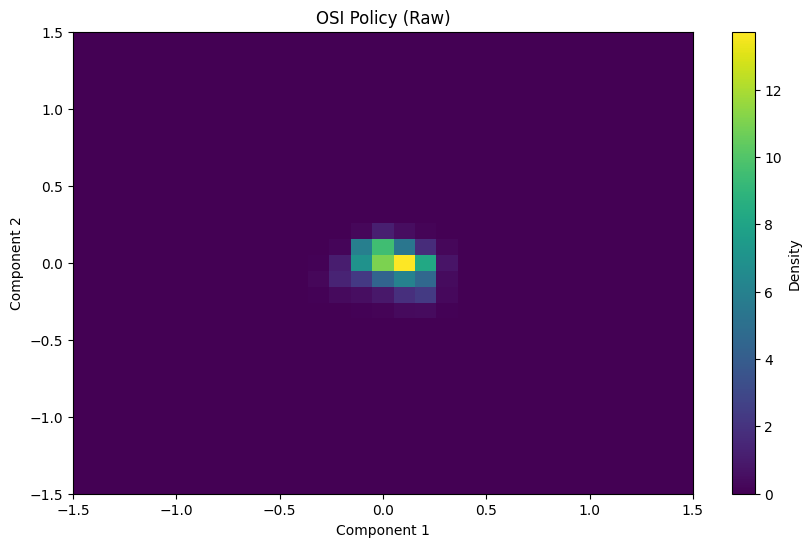

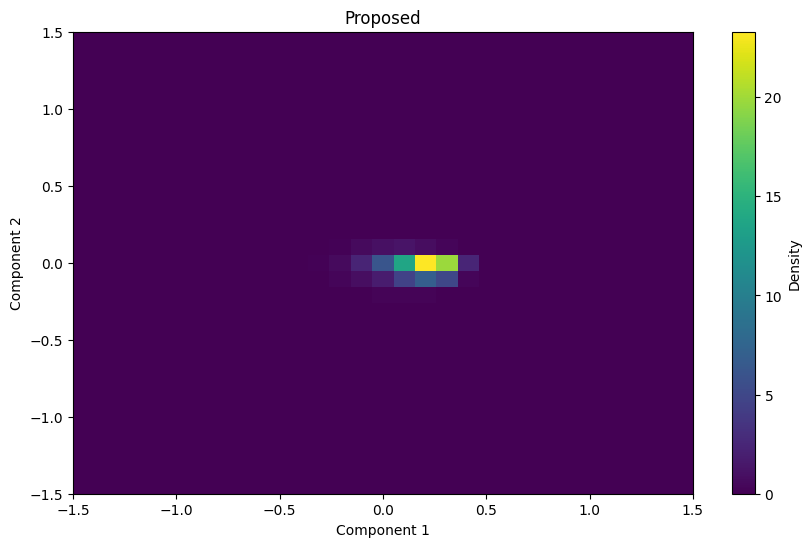

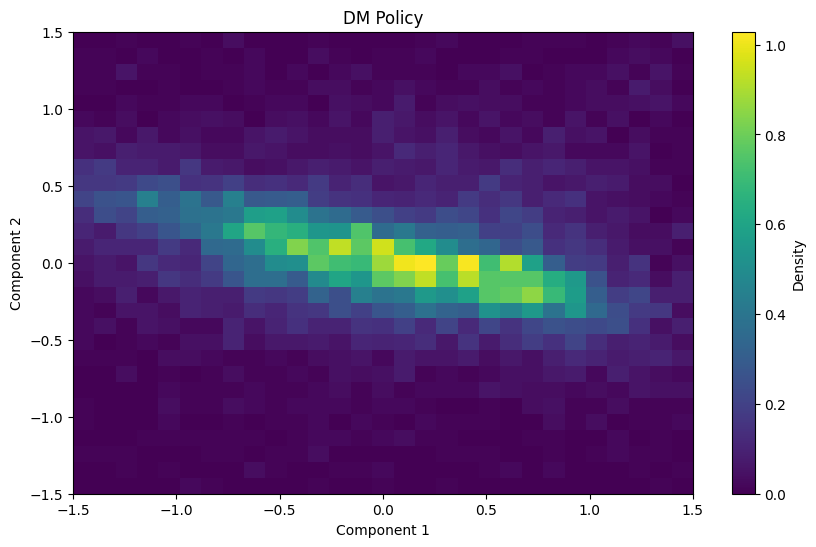

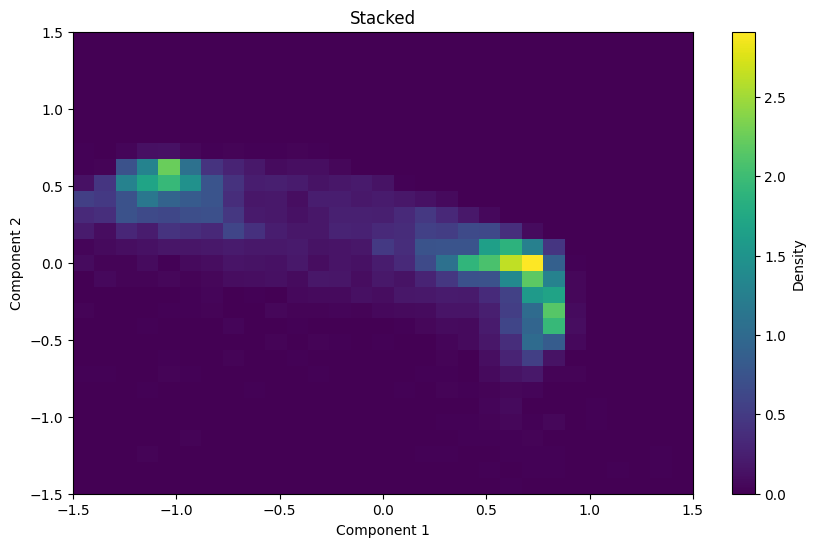

In [70]:
import matplotlib.pyplot as plt
import numpy as np

sys_params = [
    '0.75, 0.75', '0.75, 1.00', '0.75, 1.25',
    '1.00, 0.75', '1.00, 1.00', '1.00, 1.25',
    '1.25, 0.75', '1.25, 1.00', '1.25, 1.25',
    '0.50, 0.50', '0.50, 1.50',
    '1.50, 0.50', '1.50, 1.50'
]

method_names = [
    'Oracle Policy', 'OSI Policy', 'OSI Policy (Raw)',
    'Proposed', 'DM Policy', 'Stacked'
]

step_size = embeddings_2d_pcas[list(embeddings_2d_pcas.keys())[0]].shape[0]//13
random_sample_ratio = 0.01
random_sample_idx = np.random.permutation(step_size)[:int(step_size * random_sample_ratio)]

cmaps = ['', 'viridis', 'plasma', 'inferno', 'magma']

for train_env_idx, train_env_name in enumerate(contexts):
    embeddings_2d_pca = embeddings_2d_pcas[train_env_name]

    plt.figure(figsize=(10, 6))
    for test_env_idx, (test_env_name, context) in enumerate(contexts[train_env_name].items()):
        if test_env_name == 'ALL':
            continue

        if 'Easy' in test_env_name:
            continue

        if 'Hard1' not in test_env_name:
            continue

        target_embeddings = embeddings_2d_pca[test_env_idx*step_size:test_env_idx*step_size+step_size]
        target_embeddings = target_embeddings[random_sample_idx]

        x=target_embeddings[:,0];y=target_embeddings[:,1]
        # Setting the bins for the histogram
        # xbins = np.linspace(embeddings_2d_pca[-step_size*4:,0].min(), embeddings_2d_pca[-step_size*4:,0].max(), 30)
        # ybins = np.linspace(embeddings_2d_pca[-step_size*4:,1].min(), embeddings_2d_pca[-step_size*4:,1].max(), 30)
        xbins = np.linspace(-1.5, 1.5, 30)
        ybins = np.linspace(-1.5, 1.5, 30)

        plt.hist2d(x, y, bins=[xbins, ybins], cmap=cmaps[int(test_env_name[-1])], density=True, alpha=1, label=sys_params[test_env_idx])

        # plt.scatter(target_embeddings[:, 0], target_embeddings[:, 1], label=sys_params[test_env_idx])
        plt.colorbar(label='Density')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    # plt.legend(title='Environments')
    # plt.title('PCA-reduced Embeddings')
    plt.title(f'{method_names[train_env_idx]}')
    # plt.xlim(-5, 5)
    # plt.ylim(-5, 5)
    plt.show()

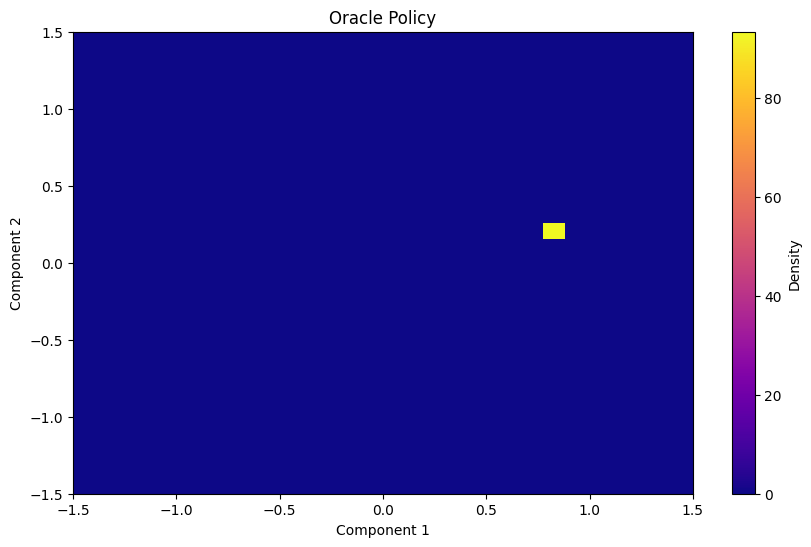

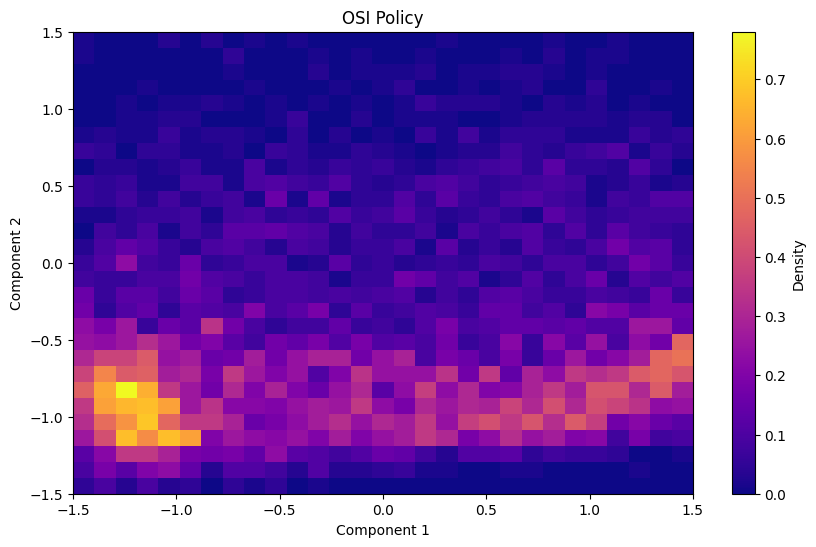

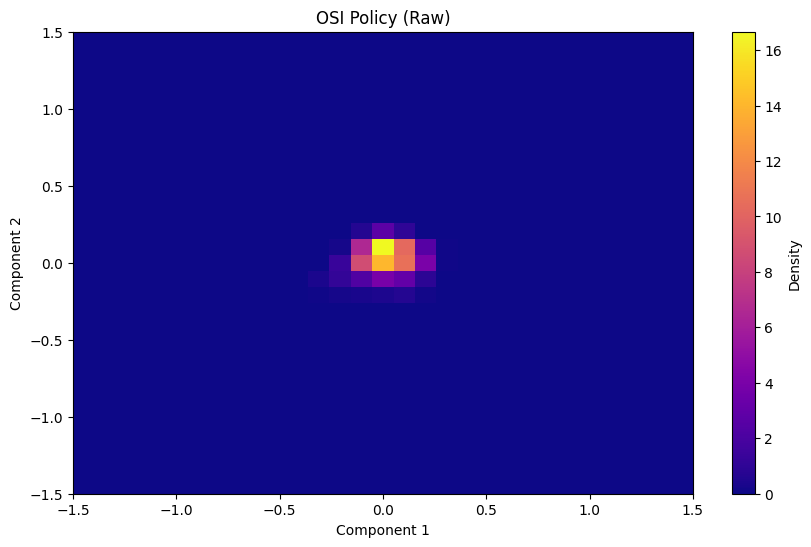

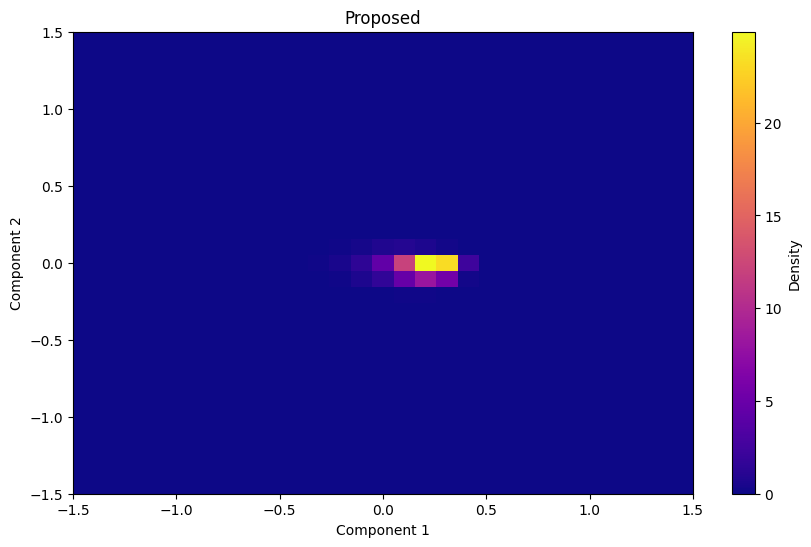

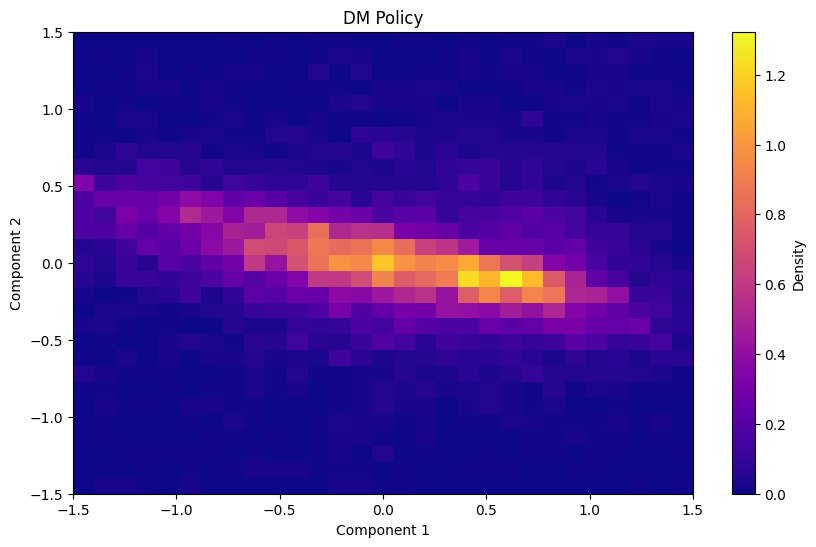

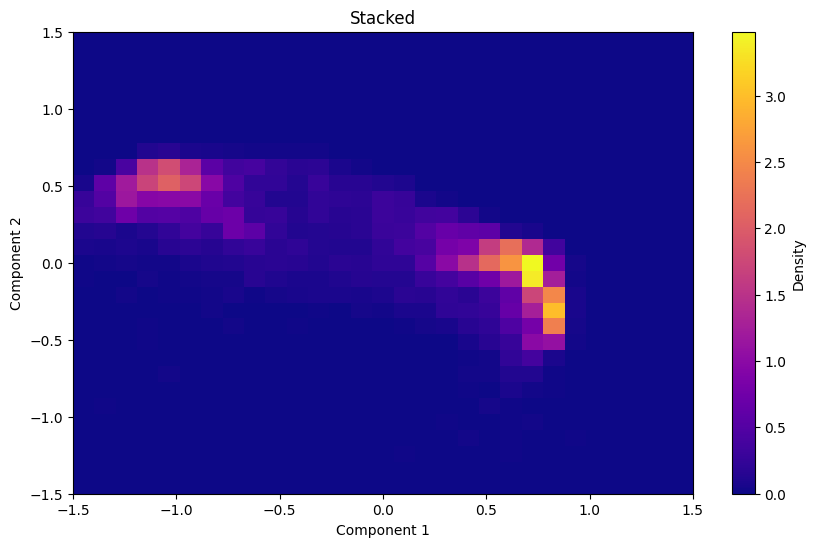

In [71]:
import matplotlib.pyplot as plt
import numpy as np

sys_params = [
    '0.75, 0.75', '0.75, 1.00', '0.75, 1.25',
    '1.00, 0.75', '1.00, 1.00', '1.00, 1.25',
    '1.25, 0.75', '1.25, 1.00', '1.25, 1.25',
    '0.50, 0.50', '0.50, 1.50',
    '1.50, 0.50', '1.50, 1.50'
]

method_names = [
    'Oracle Policy', 'OSI Policy', 'OSI Policy (Raw)',
    'Proposed', 'DM Policy', 'Stacked'
]

step_size = embeddings_2d_pcas[list(embeddings_2d_pcas.keys())[0]].shape[0]//13
random_sample_ratio = 0.01
random_sample_idx = np.random.permutation(step_size)[:int(step_size * random_sample_ratio)]

cmaps = ['', 'viridis', 'plasma', 'inferno', 'magma']

for train_env_idx, train_env_name in enumerate(contexts):
    embeddings_2d_pca = embeddings_2d_pcas[train_env_name]

    plt.figure(figsize=(10, 6))
    for test_env_idx, (test_env_name, context) in enumerate(contexts[train_env_name].items()):
        if test_env_name == 'ALL':
            continue

        if 'Easy' in test_env_name:
            continue

        if 'Hard2' not in test_env_name:
            continue

        target_embeddings = embeddings_2d_pca[test_env_idx*step_size:test_env_idx*step_size+step_size]
        target_embeddings = target_embeddings[random_sample_idx]

        x=target_embeddings[:,0];y=target_embeddings[:,1]
        # Setting the bins for the histogram
        # xbins = np.linspace(embeddings_2d_pca[-step_size*4:,0].min(), embeddings_2d_pca[-step_size*4:,0].max(), 30)
        # ybins = np.linspace(embeddings_2d_pca[-step_size*4:,1].min(), embeddings_2d_pca[-step_size*4:,1].max(), 30)
        xbins = np.linspace(-1.5, 1.5, 30)
        ybins = np.linspace(-1.5, 1.5, 30)

        plt.hist2d(x, y, bins=[xbins, ybins], cmap=cmaps[int(test_env_name[-1])], density=True, alpha=1, label=sys_params[test_env_idx])

        # plt.scatter(target_embeddings[:, 0], target_embeddings[:, 1], label=sys_params[test_env_idx])
        plt.colorbar(label='Density')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    # plt.legend(title='Environments')
    # plt.title('PCA-reduced Embeddings')
    plt.title(f'{method_names[train_env_idx]}')
    # plt.xlim(-5, 5)
    # plt.ylim(-5, 5)
    plt.show()

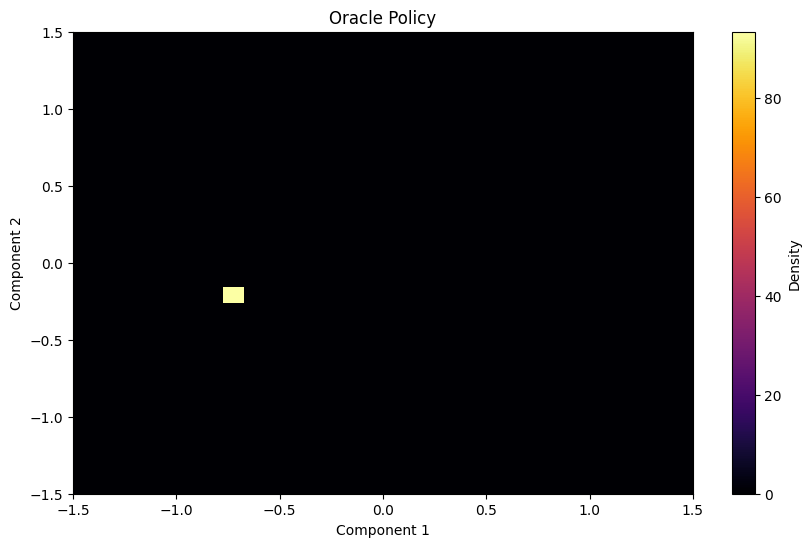

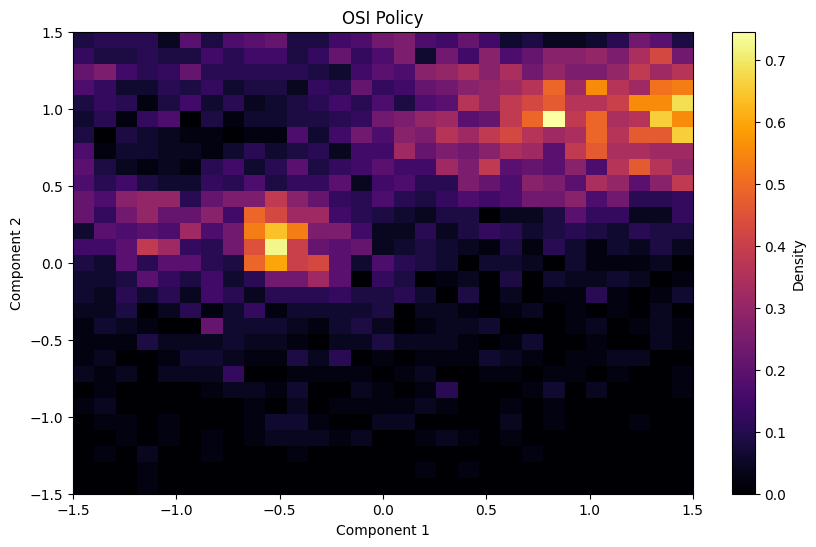

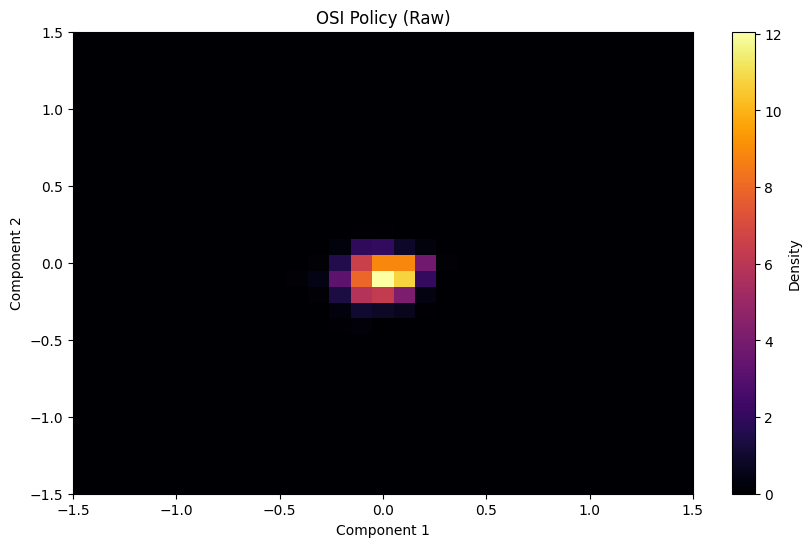

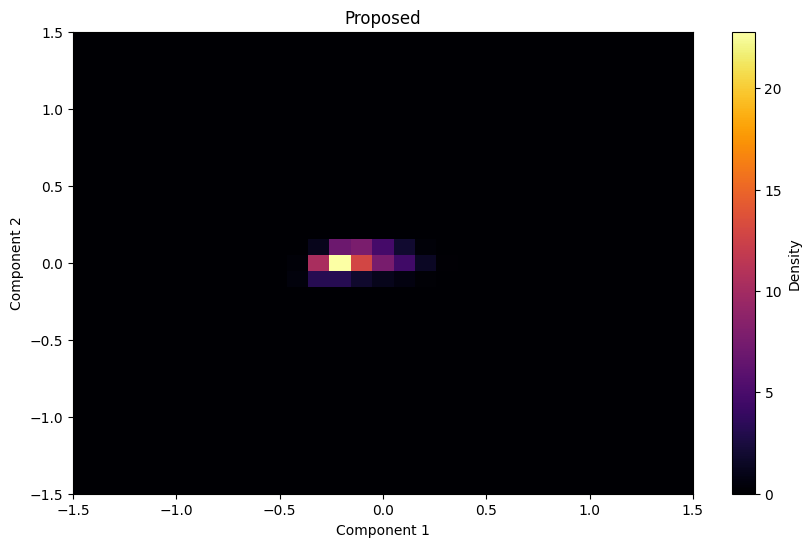

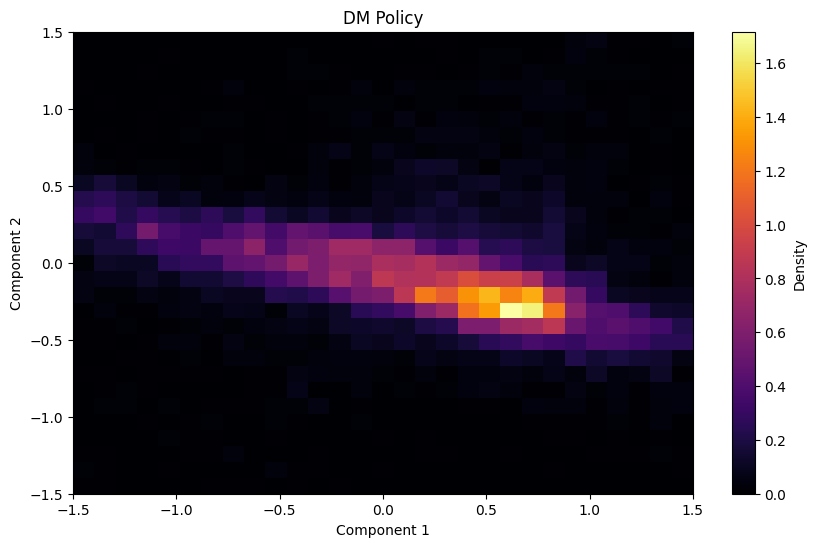

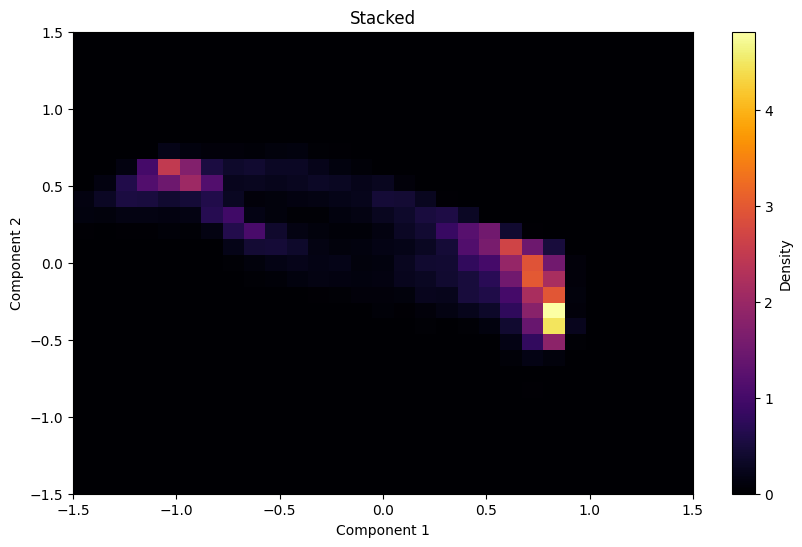

In [72]:
import matplotlib.pyplot as plt
import numpy as np

sys_params = [
    '0.75, 0.75', '0.75, 1.00', '0.75, 1.25',
    '1.00, 0.75', '1.00, 1.00', '1.00, 1.25',
    '1.25, 0.75', '1.25, 1.00', '1.25, 1.25',
    '0.50, 0.50', '0.50, 1.50',
    '1.50, 0.50', '1.50, 1.50'
]

method_names = [
    'Oracle Policy', 'OSI Policy', 'OSI Policy (Raw)',
    'Proposed', 'DM Policy', 'Stacked'
]

step_size = embeddings_2d_pcas[list(embeddings_2d_pcas.keys())[0]].shape[0]//13
random_sample_ratio = 0.01
random_sample_idx = np.random.permutation(step_size)[:int(step_size * random_sample_ratio)]

cmaps = ['', 'viridis', 'plasma', 'inferno', 'magma']

for train_env_idx, train_env_name in enumerate(contexts):
    embeddings_2d_pca = embeddings_2d_pcas[train_env_name]

    plt.figure(figsize=(10, 6))
    for test_env_idx, (test_env_name, context) in enumerate(contexts[train_env_name].items()):
        if test_env_name == 'ALL':
            continue

        if 'Easy' in test_env_name:
            continue

        if 'Hard3' not in test_env_name:
            continue

        target_embeddings = embeddings_2d_pca[test_env_idx*step_size:test_env_idx*step_size+step_size]
        target_embeddings = target_embeddings[random_sample_idx]

        x=target_embeddings[:,0];y=target_embeddings[:,1]
        # Setting the bins for the histogram
        # xbins = np.linspace(embeddings_2d_pca[-step_size*4:,0].min(), embeddings_2d_pca[-step_size*4:,0].max(), 30)
        # ybins = np.linspace(embeddings_2d_pca[-step_size*4:,1].min(), embeddings_2d_pca[-step_size*4:,1].max(), 30)
        xbins = np.linspace(-1.5, 1.5, 30)
        ybins = np.linspace(-1.5, 1.5, 30)

        plt.hist2d(x, y, bins=[xbins, ybins], cmap=cmaps[int(test_env_name[-1])], density=True, alpha=1, label=sys_params[test_env_idx])

        # plt.scatter(target_embeddings[:, 0], target_embeddings[:, 1], label=sys_params[test_env_idx])
        plt.colorbar(label='Density')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    # plt.legend(title='Environments')
    # plt.title('PCA-reduced Embeddings')
    plt.title(f'{method_names[train_env_idx]}')
    # plt.xlim(-5, 5)
    # plt.ylim(-5, 5)
    plt.show()

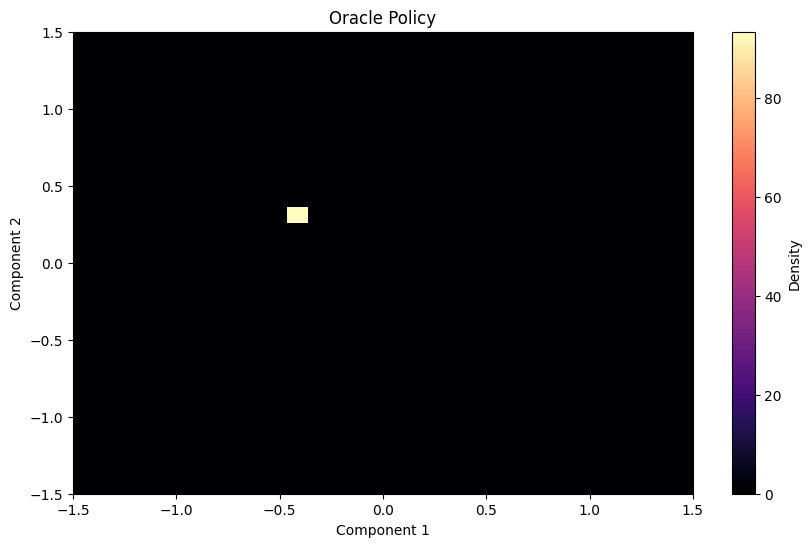

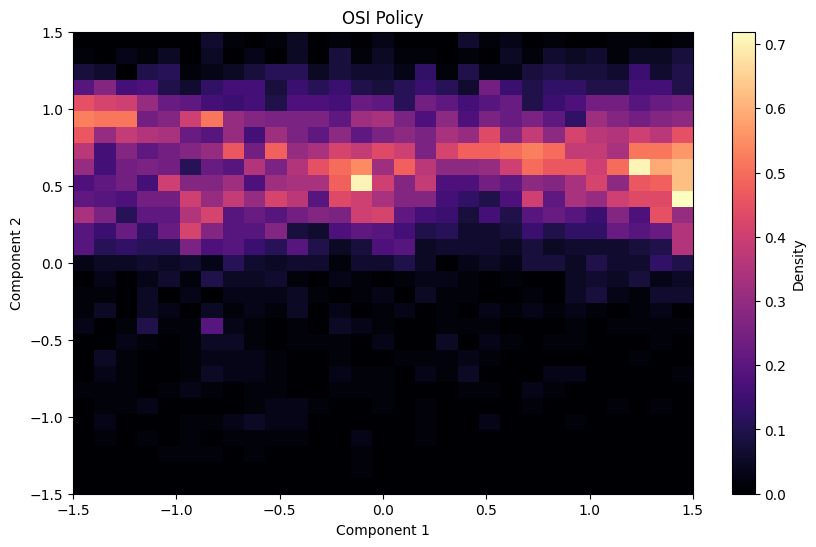

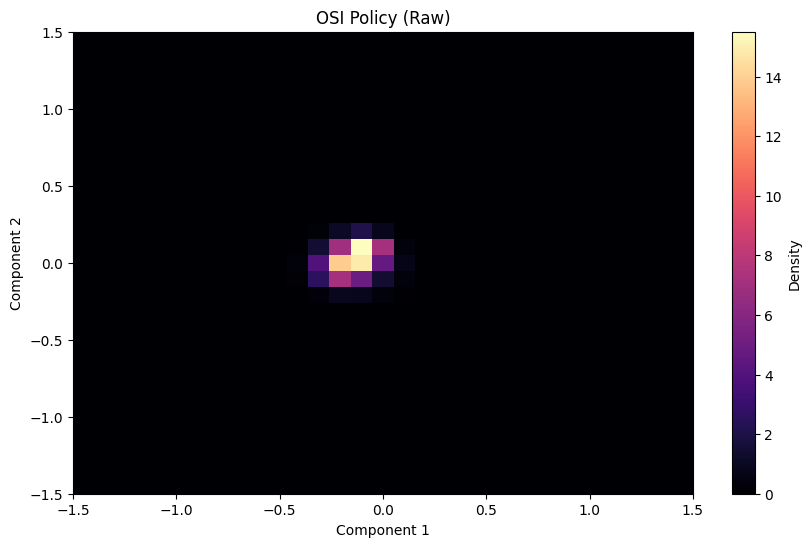

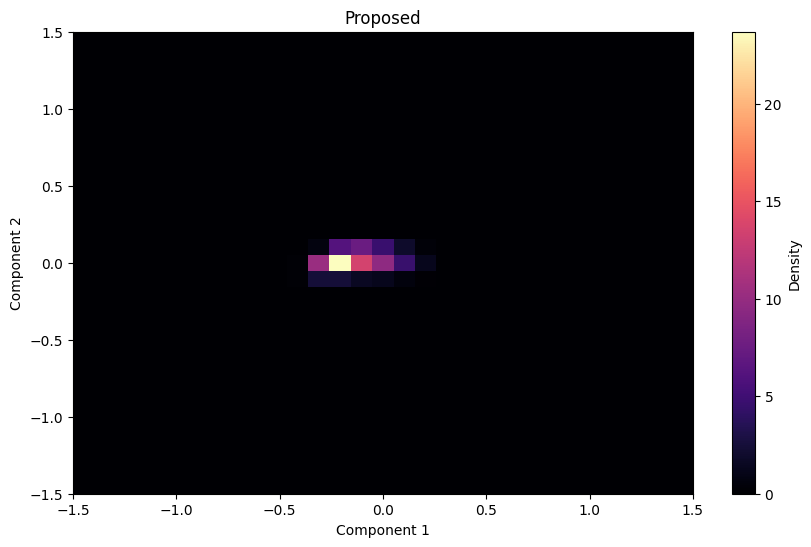

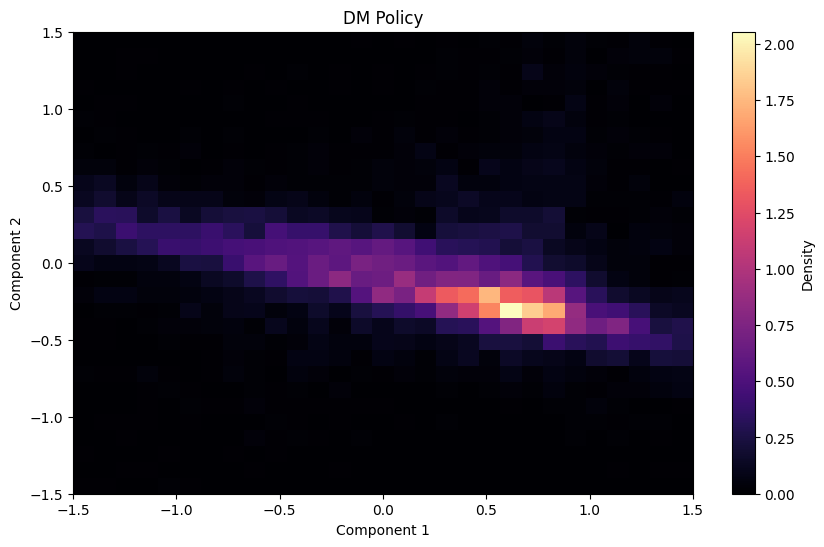

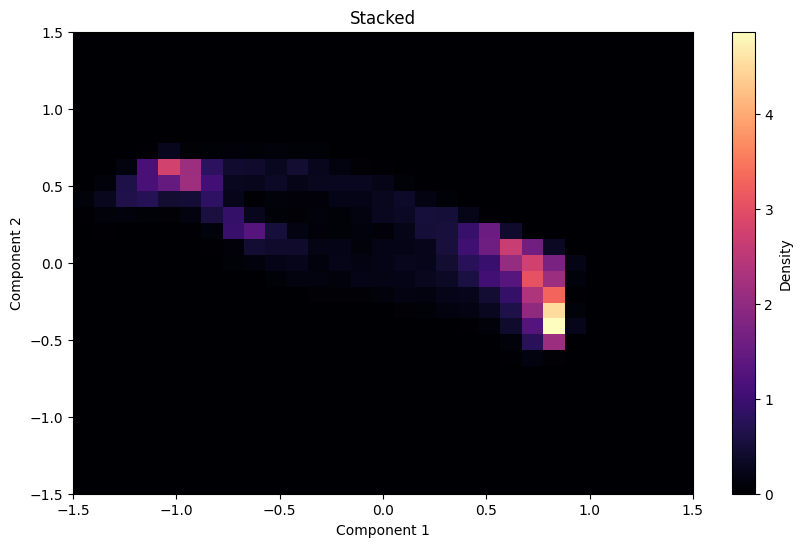

In [73]:
import matplotlib.pyplot as plt
import numpy as np

sys_params = [
    '0.75, 0.75', '0.75, 1.00', '0.75, 1.25',
    '1.00, 0.75', '1.00, 1.00', '1.00, 1.25',
    '1.25, 0.75', '1.25, 1.00', '1.25, 1.25',
    '0.50, 0.50', '0.50, 1.50',
    '1.50, 0.50', '1.50, 1.50'
]

method_names = [
    'Oracle Policy', 'OSI Policy', 'OSI Policy (Raw)',
    'Proposed', 'DM Policy', 'Stacked'
]

step_size = embeddings_2d_pcas[list(embeddings_2d_pcas.keys())[0]].shape[0]//13
random_sample_ratio = 0.01
random_sample_idx = np.random.permutation(step_size)[:int(step_size * random_sample_ratio)]

cmaps = ['', 'viridis', 'plasma', 'inferno', 'magma']

for train_env_idx, train_env_name in enumerate(contexts):
    embeddings_2d_pca = embeddings_2d_pcas[train_env_name]

    plt.figure(figsize=(10, 6))
    for test_env_idx, (test_env_name, context) in enumerate(contexts[train_env_name].items()):
        if test_env_name == 'ALL':
            continue

        if 'Easy' in test_env_name:
            continue

        if 'Hard4' not in test_env_name:
            continue

        target_embeddings = embeddings_2d_pca[test_env_idx*step_size:test_env_idx*step_size+step_size]
        target_embeddings = target_embeddings[random_sample_idx]

        x=target_embeddings[:,0];y=target_embeddings[:,1]
        # Setting the bins for the histogram
        # xbins = np.linspace(embeddings_2d_pca[-step_size*4:,0].min(), embeddings_2d_pca[-step_size*4:,0].max(), 30)
        # ybins = np.linspace(embeddings_2d_pca[-step_size*4:,1].min(), embeddings_2d_pca[-step_size*4:,1].max(), 30)
        xbins = np.linspace(-1.5, 1.5, 30)
        ybins = np.linspace(-1.5, 1.5, 30)

        plt.hist2d(x, y, bins=[xbins, ybins], cmap=cmaps[int(test_env_name[-1])], density=True, alpha=1, label=sys_params[test_env_idx])

        # plt.scatter(target_embeddings[:, 0], target_embeddings[:, 1], label=sys_params[test_env_idx])
        plt.colorbar(label='Density')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    # plt.legend(title='Environments')
    # plt.title('PCA-reduced Embeddings')
    plt.title(f'{method_names[train_env_idx]}')
    # plt.xlim(-5, 5)
    # plt.ylim(-5, 5)
    plt.show()